### Imported Libraries

In [1]:
import pandas as pd
import numpy as np
import miceforest as mf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier 
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

### Imported Data

In [2]:
pred_df = pd.read_excel(r"C:\Users\hanna\Downloads\recruiting_zeta-disease_prediction-data_take-home-challenge (1).xlsx")
df = pd.read_excel(r"C:\Users\hanna\Downloads\recruiting_zeta-disease_training-data_take-home-challenge.xlsx")

### Exploratory Initial Analysis

In [3]:
df

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0
...,...,...,...,...,...,...,...,...,...
795,26,161,28.4,90,78,0.5578,42,3,0
796,37,165,33.7,60,0,0.3078,69,6,1
797,27,166,25.6,74,0,0.2638,0,5,0
798,109,139,28.1,66,94,0.2298,53,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 800 non-null    int64  
 1   weight              800 non-null    int64  
 2   bmi                 800 non-null    float64
 3   blood_pressure      800 non-null    int64  
 4   insulin_test        800 non-null    int64  
 5   liver_stress_test   800 non-null    float64
 6   cardio_stress_test  800 non-null    int64  
 7   years_smoking       800 non-null    int64  
 8   zeta_disease        800 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.4 KB


As we can see, there are no missing values, which is incredibly helpful for data prediction.

In [5]:
df.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,30.985000,172.407500,32.201625,69.565000,85.887500,0.544496,43.121250,4.051250,0.348750
std,13.824025,31.942438,8.549155,19.874784,126.333656,0.348711,30.409949,4.176173,0.476873
min,18.000000,94.000000,0.000000,0.000000,0.000000,0.140800,0.000000,0.000000,0.000000
25%,21.000000,149.000000,27.300000,62.000000,0.000000,0.307800,0.000000,1.000000,0.000000
50%,26.000000,167.000000,32.050000,72.000000,45.000000,0.445300,53.000000,3.000000,0.000000
75%,38.000000,192.000000,36.525000,80.000000,130.000000,0.699800,62.000000,6.000000,1.000000
max,109.000000,308.000000,86.100000,157.000000,1077.000000,3.481300,214.000000,40.000000,1.000000


We can see some initial issues from min BMI and blood_pressure being zero, which doesn't seem physically possible. Given that both cardio_stress_test and insulin_test have both min and 25% of 0, it seems zero is a more reasonable value to have for this dataset.

### Handling "Missing" Values

In [6]:
df_missing = df.loc[(df['blood_pressure'] == 0) | (df["bmi"] == 0)]

In [7]:
df_non_missing = pd.concat([df.drop_duplicates(), df_missing]).drop_duplicates(keep=False)

In [8]:
print(len(df_missing))
print(len(df_non_missing))

39
756


In [9]:
len(df_missing)+len(df_non_missing)

795

In [10]:
df.drop_duplicates()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0
...,...,...,...,...,...,...,...,...,...
794,46,176,38.5,88,108,0.4118,66,8,0
795,26,161,28.4,90,78,0.5578,42,3,0
796,37,165,33.7,60,0,0.3078,69,6,1
797,27,166,25.6,74,0,0.2638,0,5,0


In [11]:
df[df.duplicated(keep=False)]

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
45,104,131,26.6,72,40,0.3458,48,1,0
56,109,139,28.1,66,94,0.2298,53,1,0
151,99,205,33.3,76,150,1.4158,58,11,1
374,102,129,25.4,80,37,0.6458,55,1,0
379,102,129,25.4,80,37,0.6458,55,1,0
393,99,205,33.3,76,150,1.4158,58,11,1
504,18,283,24.6,52,94,0.6998,45,2,0
703,104,131,26.6,72,40,0.3458,48,1,0
761,18,283,24.6,52,94,0.6998,45,2,0
798,109,139,28.1,66,94,0.2298,53,1,0


Looking here, one could argue that it is entirely possible for there to be two different people with identical values in every column, and given that these 5 duplicates make up <1% of the data, I'm inclined to toss these out, though it is possible we could keep these in with minimal changes to any prediction models.

#### Comparing the missing and non-missing data to the whole

In [12]:
df.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,30.985000,172.407500,32.201625,69.565000,85.887500,0.544496,43.121250,4.051250,0.348750
std,13.824025,31.942438,8.549155,19.874784,126.333656,0.348711,30.409949,4.176173,0.476873
min,18.000000,94.000000,0.000000,0.000000,0.000000,0.140800,0.000000,0.000000,0.000000
25%,21.000000,149.000000,27.300000,62.000000,0.000000,0.307800,0.000000,1.000000,0.000000
50%,26.000000,167.000000,32.050000,72.000000,45.000000,0.445300,53.000000,3.000000,0.000000
75%,38.000000,192.000000,36.525000,80.000000,130.000000,0.699800,62.000000,6.000000,1.000000
max,109.000000,308.000000,86.100000,157.000000,1077.000000,3.481300,214.000000,40.000000,1.000000


In [13]:
df_missing.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,28.794872,168.051282,23.069231,8.128205,2.282051,0.492800,5.615385,3.589744,0.435897
std,11.954254,26.318843,16.136444,24.647173,14.251406,0.326654,16.856383,3.625334,0.502356
min,18.000000,123.000000,0.000000,0.000000,0.000000,0.164800,0.000000,0.000000,0.000000
25%,21.000000,149.000000,0.000000,0.000000,0.000000,0.269800,0.000000,0.000000,0.000000
50%,25.000000,168.000000,28.000000,0.000000,0.000000,0.364800,0.000000,2.000000,0.000000
75%,33.500000,183.500000,33.350000,0.000000,0.000000,0.656800,0.000000,6.000000,1.000000
max,69.000000,233.000000,52.300000,96.000000,89.000000,1.793800,60.000000,13.000000,1.000000


In [14]:
df_non_missing.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,30.731481,172.599206,32.703175,72.736772,90.219577,0.546350,44.998677,4.080688,0.345238
std,12.906720,31.938218,7.712248,13.482322,128.408215,0.349198,29.791261,4.204393,0.475761
min,18.000000,94.000000,18.200000,24.000000,0.000000,0.140800,0.000000,0.000000,0.000000
25%,21.000000,150.000000,27.500000,64.000000,0.000000,0.309550,0.000000,1.000000,0.000000
50%,26.000000,167.000000,32.400000,72.000000,53.000000,0.451800,54.000000,3.000000,0.000000
75%,38.000000,193.000000,36.600000,80.000000,135.000000,0.704050,63.000000,6.000000,1.000000
max,109.000000,308.000000,86.100000,157.000000,1077.000000,3.481300,214.000000,40.000000,1.000000


Looking at the values here, I would argue that the non_missing data is not significantly different from that of the data as a whole; though one could test that for certainty, I see no reason to do so here, given that it is clearly evident that the missing data has a different composition in insulin_test and cardio_stress_test averages. This would seem to indicate that the data is missing at random as there does appear to be some relation between which missing values and other variables, and thus Multiple Imputation or Regression Imputation should be employed. Failing that, a "complete-case analysis" can be performed, provided that all the appropriate caveats are mentioned.

It is recommended, when using the Multiple Imputation methodology, to use as many iterations as there is a percentage of missing data, though 5 is the standard.

In [15]:
len(df_missing)/len(df.drop_duplicates())*100

4.905660377358491

Given that the amount of data missing is approximately 5%, we will be using the standard 5 iterations.

In [16]:
df2 = df.drop_duplicates()

df2["bmi"] = df2["bmi"].replace(0, np.NaN)
df2["blood_pressure"] = df2["blood_pressure"].replace(0, np.NaN)

df2 = df2.reset_index(drop=True)

C:\Users\hanna\AppData\Local\Temp\ipykernel_28492\3099549023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["bmi"] = df2["bmi"].replace(0, np.NaN)
C:\Users\hanna\AppData\Local\Temp\ipykernel_28492\3099549023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["blood_pressure"] = df2["blood_pressure"].replace(0, np.NaN)


In [17]:
kernel = mf.ImputationKernel(df2, random_state=2024)
kernel.mice(5, n_estimators = len(df_missing))
df_mi = kernel.complete_data()

Now it should be the case that the "missing" values should be more accurate to what the dataset's pattern say they should be instead 

<Axes: >

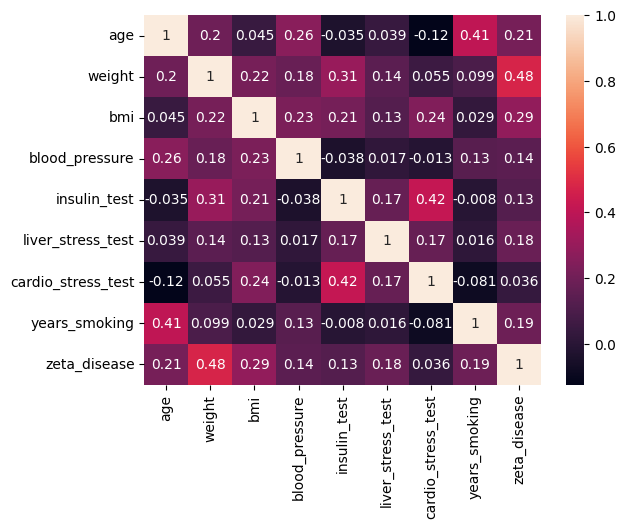

In [18]:
sns.heatmap(df_mi.corr(), annot=True)

And so we see that the highest correlations (still not that strong) are weight with the disease, years_smoking with age (understandable, they are both measured in years, and years_smoking is limited to a max of what the age is), and insulin_test with cardio_stress_test (kind of seen in how both insulin_test and cardio_stress test both had lower averages in connection with the missing values).

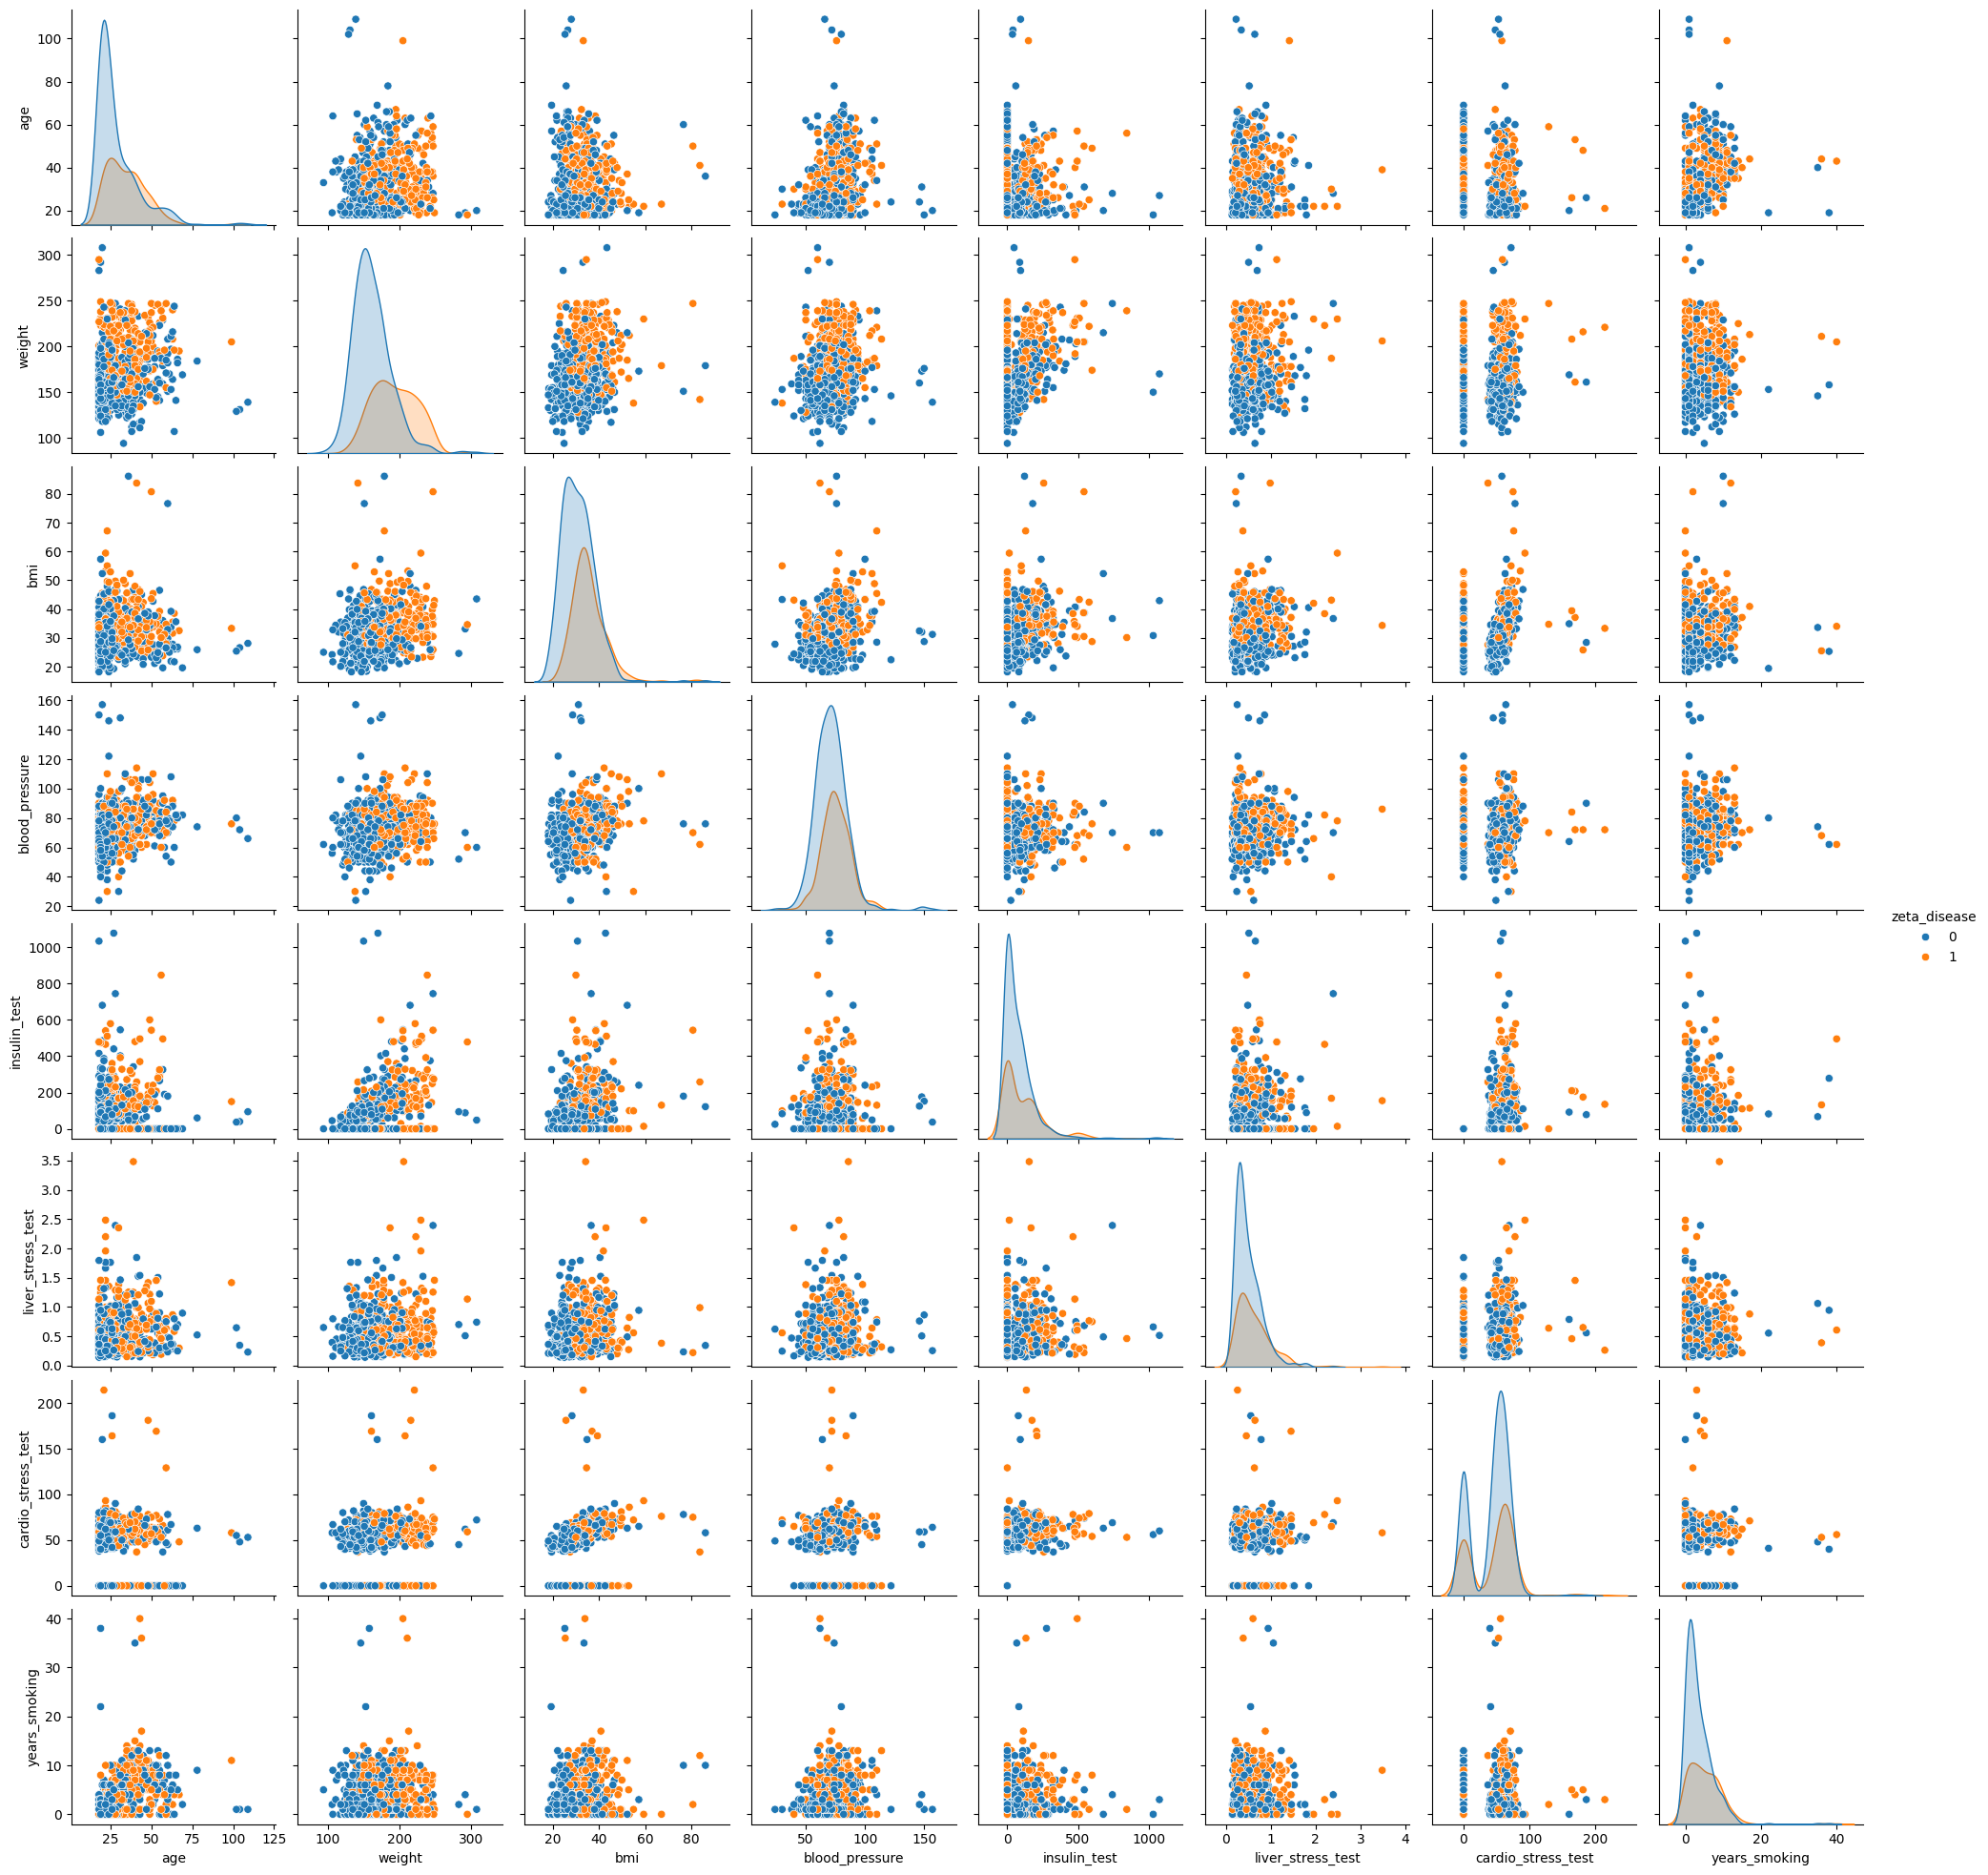

In [19]:
sns.pairplot(df_mi, hue='zeta_disease')

And as seen above here, there's no two easy axis on which we can easily separate the haves and the have-nots for our data, but such is often the case.

## Logistic Regression

The first prediction model that we'll use here is Logistic Regression. However, to ensure that the model is not overfit, we'll be splitting the data into a training and test set. The easiest way to do that is to use the back X% (in our case 10%) of the dataframe as our test set. However, there is a chance, however slight, that the data in our dataset had some sort of order in it when it was put into the excel file; and so we will need to first randomize the rows of our dataframe to make sure that any order initially in the dataframe is removed.

### Randomizing Data order

In [20]:
df_random = df_mi.sample(frac=1, random_state = 2024).reset_index(drop=True)

In [21]:
df_test = df_random[-80:]
df_train = df_random[:-80]

In [22]:
y_values = df_train.pop("zeta_disease")
y_test = df_test.pop("zeta_disease")

In [23]:
from sklearn.linear_model import LogisticRegressionCV

In [24]:
model = LogisticRegressionCV(cv=9, random_state=2024).fit(df_train, y_values)

C:\Users\hanna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hanna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [25]:
model.score(df_train, y_values)

0.7776223776223776

In [26]:
predictions = model.predict(df_test)

In [27]:
print(accuracy_score(predictions, y_test))

0.725


So, given that our training accuracy is 77.8%, and our testing accuracy is 72.5%, it's decently accurate at predictng values and not very overfitted, but let's see if we can't make it even better.

## Support Vector Machines

In [28]:
model = SVC(kernel="linear")
model.fit(df_train, y_values)
print(model.score(df_train,y_values))

0.7846153846153846


In [29]:
predictions = model.predict(df_test)
print(accuracy_score(predictions, y_test))

0.725


In [30]:
model = SVC(kernel="poly")
model.fit(df_train, y_values)
print(model.score(df_train,y_values))

0.779020979020979


In [31]:
predictions = model.predict(df_test)
print(accuracy_score(predictions, y_test))

0.7125


In [32]:
model = SVC(kernel="rbf")
model.fit(df_train, y_values)
print(model.score(df_train,y_values))

0.7678321678321678


In [33]:
predictions = model.predict(df_test)
print(accuracy_score(predictions, y_test))

0.7125


In [34]:
model = SVC(kernel="sigmoid")
model.fit(df_train, y_values)
print(model.score(df_train,y_values))

0.4699300699300699


In [35]:
predictions = model.predict(df_test)
print(accuracy_score(predictions, y_test))

0.5125


Clearly, among these models, the linear kernel proves to be the most accurate, with a training accuracy of 78.5% and an testing accuracy of 72.5%. This is the same accuracy as with our logistic regression model, though the training accuracy is slightly higher. We might be able to do even better with a more complex model though.

## XGBoost

In [36]:
model_params = {
    "max_depth": [3,5,7,9],
    "learning_rate": [0.2, 0.1, 0.05, 0.01],
    "subsample": [0.5, 0.75, 1]
 }

xgb_model = XGBClassifier()

In [37]:
grid_search_tune = GridSearchCV(xgb_model, model_params,cv=9, scoring="accuracy")

grid_search_tune.fit(df_train, y_values)

grid_search_tune.best_score_

0.7819268635724331

In [38]:
predictions = grid_search_tune.predict(df_test)
print(accuracy_score(predictions, y_test))

0.7


Now, the training accuracy is 78.2%, but the testing accuracy is only 70.0%. So, further refinement might improve this, but currently, the SVC with the linear kernel has the best testing accuracy.

### LightGBM

In [39]:
model_params = {
    "max_depth": [3,5,7,9],
    "learning_rate": [0.2, 0.1, 0.01, 0.001],
    "subsample": [0.5, 0.75, 1],
 }

lgbm_model = LGBMClassifier()

In [40]:
grid_search_tune = GridSearchCV(lgbm_model, model_params,cv=9, scoring="accuracy")

grid_search_tune.fit(df_train, y_values)

grid_search_tune.best_score_

0.7637658227848101

In [41]:
predictions = grid_search_tune.predict(df_test)
print(accuracy_score(predictions, y_test))

0.6875


Now, the training accuracy is 76.4%, but the testing accuracy is only 68.8%. So, further refinement might improve this, but currently, the SVC with the linear kernel has the best testing accuracy.

## Random Forest

In [42]:
model_params = {
    "max_depth": [3,5,7,9],
    "max_leaf_nodes": [3,5,7],
    "n_estimators": [10,30,50,70,90]
 }

In [43]:
rf_model = RandomForestClassifier()

In [44]:
grid_search_tune = GridSearchCV(rf_model, model_params,cv=9, scoring="accuracy")

grid_search_tune.fit(df_train, y_values)

grid_search_tune.best_score_

0.7735056258790436

In [45]:
predictions = grid_search_tune.predict(df_test)
print(accuracy_score(predictions, y_test))

0.7125


Now, the training accuracy is 77.1%, but the testing accuracy is only 70.0%. So, further refinement might improve this, but currently, the SVC with the linear kernel has the best testing accuracy.

We could, in further exploration, further refine the above models to get the best testing accuracy we can, and use more parameters in order to even further refine, but I believe what we have is sufficient for now as an example. We could also develop a neural network to train for this binary classification problem, though that is usually reserved for image, audio, and text classification.

## Creating Predictions

In [46]:
pred_ys = pred_df.pop("zeta_disease")

In [47]:
model = SVC(kernel="linear")
model.fit(df_train, y_values)

predictions = model.predict(pred_df)

In [48]:
pred_df["zeta_disease"] = predictions